Kaggle link: https://www.kaggle.com/burakhmmtgl/predict-molecular-properties

In [ ]:
# Algo isn't good for small molecules!! NH3, CO, CCl4 all did problems

# Open Tasks

# B_i features
    # fix documentation of neighbors data

# Bond features
    # logical error - aromtic bonds needs to be defined prop, or accept half numbers
    # change final output to int

# Angle features
    # add neigbors indices as forbidden features
    # when bonded_count = 1 - do nothing
    # when bonded_count = 2 - pass to angle the 3 points. 
    # when bonded_count = 3 - Mean angle / Bond df constructor
    # when bonded_count = 4 - Mean angle / Bond df constructor

# Hybridisation features 
    # Maybe count bonded_atoms + lone pairs?
    # Number of Hybridization = Valence electron + monovalent + (negative charge) – (positive charge)/2
    # Monovalent: An atom having just one covalent bond
    # I3- has hyb of sp3d and angle of 180
    # after you have all the bonds of the molecloue - write algo to identidy hybridisation by bonded atom count
    # focus on the main three:
    # Linear - sp hybridisation (180°) - CO2
    # Trigonal planar - sp2 hybridisation (120°) - BCl3
    # Tetrahedral - sp3 hybridisation (109.5°) - CCl4

# Feature selector - nested hypertuning
    # nested testing - find opt for 100 data points, then expend the data point and opt again in smaller ranges, and so on - sort of grad_decent

# Order:
# Clean data
# Add interaction features
# Scale
# Feature selection
# Feature itteration
# Hyper parameter finetune
# Confuction matrix
# ROC=AUC curve
# Recall precision curve
# Several suggestted models and performance

In [ ]:
# Architecture:

#            DataFrameCreator
#                                            MoleculeDataContainer
# Utlis ---> BondFeaturesExtractor      --->                        ---> FeatureExtractor
#                                            AtomDataContainer
#            LocationFeaturesExtractor
# <---------    Inner level      --------->  <---------    Outter level      --------->

In [ ]:
# Inner level

############################################
################# Utils ####################
############################################

class Utils ():
    forbidden_molecule_attrs = ('atoms', 'shapeM')
    forbidden_atom_attrs = ('line_dict', 'xyz')

    feature_names_interpeter = {'id': 'cid', # DONT CHANGE - critical for the merge
                                'En': 'Binding Energy [kcal/mol]',
                                'shapeM_coef': 'Multipole coefficient',
                                'atom_count': 'Number of ATOM atoms',
                                'atom_location': 'COORDINATE location',
                                'atom_mean_location': 'ATOM COORDINATE location mean',
                                'atom_std_location': 'ATOM COORDINATE location std',
                                'neighbor_type': 'neighbor NEIGHBOR_NUMBER',
                                'neighbor_distance': 'neighbor NEIGHBOR_NUMBER distance [A]',
                                'neighbor_angle': 'neighbor NEIGHBOR_NUMBER angle [deg]',
                                'bond_count': 'Number of BOND bonds',
                                'bonded_atoms_count': 'Number of bonded atoms',
                                'bond_length_deviation': 'Mean deviation of BOND bonds length from theory [%]',
                                'COOH_group_count': 'Number of COOH groups',
                                'b_vector_coef' : 'B',
                                }

    def get_flat_list(self, list_of_lists):
        """
        Given a list where are all the items are list themselves, returns a single list where the items are the items of the inner lists
    
        Parameters
        ----------
        
        list_of_lists : list
            List of lists, meaning that items of the list are lists as well.
 
        Returns
        -------

        List
            List where all the items are the items of the inner lists
        
        Examples
        --------

        >>> operating_tool = Utils()
        >>> list_of_lists [[6, 5], [8, 9], [2]]
        >>> operating_tool.get_flat_list(list_of_lists)
            [6, 5, 8, 9, 2]
        """
        return [item for sublist in list_of_lists for item in sublist]

    def merge_dicts(self, *dicts):
        """
        Given dictionaries, returns a merge dictionary with all the items combined. the function assumes that is no joint keys
    
        Parameters
        ----------

        dicts : dict kargs
            The dictionaries intended for merging
 
        Returns
        -------

        Dictionary
            Dictionary with all the items from the given dictionaries
        
        Examples
        --------

        >>> operating_tool = Utils()
        >>> dict_1 = {'a': 1, 'b': 2}
        >>> dict_2 = {'c': 3}
        >>> dict_3 = {'d': 4, 'e': 5, 'f': 6}
        >>> operating_tool.merge_dicts(dict_1, dict_2, dict_3)
            {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6}
        """
        merged_dict = {k: v for d in dicts for k, v in d.items()}
        return merged_dict

    def get_releative_error(self, value_1, value_2):
        """
        Given two values, returns the relative error between the two values.
    
        Parameters
        ----------

        value_1, value_2 : float.
 
        Returns
        -------

        Float
            The relative error between value_1 and value_2 im percents
        
        Examples
        --------

        >>> operating_tool = Utils()
        >>> operating_tool.get_releative_error(5.3, 7.4)
        39.623
        """
        return round(100*abs(value_1-value_2)/min(value_1, value_2),3)

    def get_angle_between_by_three_points (self, point_1, point_2, point_3, radian_units = False):
        """
        Given 3 points in space (2D/3D), returns the angle between those three points in degrees.
    
        Parameters
        ----------

        point_1, point_2, point_3 : array-like.

        radian_units : bool, default : False.
            Determines the units of the final output. If True the answer will be in radians, otherwise it will be in degrees.
 
        Returns
        -------

        Float
            The angle between those three points in radians or degrees
        
        Examples
        --------

        >>> operating_tool = Utils()
        >>> operating_tool.get_angle_between_by_three_points([0, 1], [1, 0], [2, 1])
        90.0
        >>> operating_tool.get_angle_between_by_three_points([0, 1], [1, 0], [2, 1], True)
        1.57
        """
        import numpy as np
        vector_1, vector_2 = np.subtract(point_1, point_2), np.subtract(point_3, point_2)
        # if vector_1.all() == vector_2.all():
        #     return 0
        angle = np.arccos(np.dot(vector_1, vector_2) / (np.linalg.norm(vector_1) * np.linalg.norm(vector_2)))
        if radian_units:
            return round(angle, 2)
        return round(180*angle/np.pi,2)


    def get_object_features(self, forbidden_attrs):
        """
        A function returns a reduced version of the __dict__ method
    
        Parameters
        ----------

        forbidden_attr : list.
            A list of attr that needed to be reduced for the full attr dict of the calling object

        Returns
        -------

        Dictionary
            A reduced Dictionary of calling objects attrs
        
        Examples
        --------

        >>> operating_tool = Utils()
        >>> setattr (operating_tool, 'A', 1)
        >>> setattr (operating_tool, 'B', 2)
        >>> operating_tool.__dict__
        {'A': 1, 'B': 2}
        >>> operating_tool.get_object_features(['A'])
        {'B': 2}
        """
        reduced_attr_dict = {key: value for key, value in self.__dict__.items() if not key in forbidden_attrs}
        return reduced_attr_dict

    def get_feature_name(self, feature_name_template, **kwargs):
        """
        A function that translate a feature name code/template to an actual and final feature name 
    
        Parameters
        ----------

        feature_name_template : str.
            A str of the raw feature name. This value should be one of the keys of "feature_names_interpeter"

        kwargs
            Any desired replacement to be made in the final feature name  

        Returns
        -------

        Str
            A str of the final feature name
        
        Examples
        --------

        >>> operating_tool = Utils()
        >>> operating_tool.feature_names_interpeter
        {'id': 'cid', # DONT CHANGE - critical for the merge
         'En': 'Binding Energy [eV]',
         'atom_count': 'Number of ATOM atoms',
         'atom_mean_location': 'ATOM COORDINATE location mean',
         ...
         ...
        >>> operating_tool.get_feature_name('En')
        'Binding Energy [eV]'
        >>> operating_tool.get_feature_name('atom_count', ATOM = 'O')
        'Number of O atoms'
        >>> operating_tool.get_feature_name('atom_mean_location', ATOM = 'O', COORDINATE = 'y')
        'O y location mean'
        """
        final_feature_name = self.feature_names_interpeter.get(feature_name_template, feature_name_template)
        if kwargs:
            for word_code, word_replacement in kwargs.items():
                final_feature_name = final_feature_name.replace(word_code, word_replacement)
        return final_feature_name

#######################################################
################# DataFrameCreator ####################
#######################################################

class DataFrameCreator (Utils):
    def get_columns_at_high_missing_percentile(self, df, missing_percentile_threshold = 0.8):
        """
        Function that checks for the percentile of missing data in all the columns of a DataFrame.
        The function an index list of the column names that have more missing values then the set thershold 
    
        Parameters
        ----------

        df : DataFrame
            A pamdas dataframe

        missing_percentile_threshold: float, default 0.8
            The maximum thershold for missing data percentile. the name of every column that has more missing
            data then this thershold will be dropped from the DataFrame.
        
        Returns
        -------

        IndexList
            A DataFrame created from the provided data.
        
        Examples
        --------

        >>> df_creator = DataFrameCreator()
        >>> import pandas as pd
        >>> df = pd.DataFrame({'A': [-2, None, None, None, 2], 'B': [4, None, None, 1, 4]})
            A	B
        0	-2.0	4.0
        1	NaN	NaN
        2	NaN	NaN
        3	NaN	1.0
        4	2.0	4.0
        >>> df_cretor.get_columns_at_high_missing_percentile(df, 0.5)
        Index(['A'], dtype='object')
        """
        missing_data_percentile = df.isnull().sum()/len(df.index)
        column_names = missing_data_percentile[missing_data_percentile>missing_percentile_threshold].index
        return column_names

    def get_df(self, data, missing_percentile_threshold = 0.8, fill_na_value = 0):
        """
        Function creates a Dataframe from a given data, and does elementrly preprocessing. 
    
        Parameters
        ----------

        data : dict iterable
            An iterable of dictionary from which the DataFrame will be created.
            Every key of the dictionary will be a column in the resulting DataFrame

        missing_percentile_threshold: float, default 0.8
            The maximum thershold for missing data percentile. Every column that has more missing
            data then this thershold will be dropped from the DataFrame.

        fill_na_value: float, default 0.0
            A value that will be replace the missing values in the DataFrame
 
        Returns
        -------

        DataFrame
            A DataFrame created from the provided data.
        
        Examples
        --------

        >>> df_creator = DataFrameCreator()
        >>> data = {'A': [-2, None, None, None, 2], 'B': [4, None, None, 1, 4]}
        {'A': [-2, None, None, None, 2], 'B': [4, None, None, 1, 4]}
        >>> df_creator.get_df(data, 0.5, 0)
        	B
        0	4.0
        1	0.0
        2	0.0
        3	1.0
        4	4.0
        """
        import pandas as pd
        df = pd.DataFrame(data = data)
        df.drop(labels = self.get_columns_at_high_missing_percentile(df, missing_percentile_threshold), axis = 1, inplace = True)
        df.fillna(value=0, inplace=True)
        return df

########################################################
############### BondFeaturesExtractor ##################
########################################################

class BondFeaturesExtractor (Utils):   
    standard_bond_length = {'C-C': 1.54, 'C-N': 1.47, 'C-H':1.09, 'C-O': 1.43, 'C-F': 1.37, 'C-Cl': 1.76,'C-Br': 1.94,'C-I': 2.14, 'C-S': 1.82, 'C-P': 1.84,  # carbon - single bond 
                            'N-H': 0.99, 'O-H': 0.98, 'S-S': 2.07, 'P-O': 1.55, # other - single bond
                            'C=C': 1.34, 'C=O': 1.21, # double bond
                            }
    bond_coordination_number = {'C': 4, 'N': 3, 'P': 3, 'O': 2, 'H': 1}

    def get_closest_bond(self, actual_bond_length, possible_bond_1, possible_bond_2,):
        """
        Function that is given a bond length and two possible bonds, checks which theoretical bond length is closer
        to the actual bond length and returns that bond and it's deviation from that theoretical value in [%]
    
        Parameters
        ----------

        actual_bond_length : float.
            The length of the bond in [A] (10^-10 meter)

        possible_bond_1, possible_bond_2: str.
            Suspected possible bonds, like 'C-H' or 'C=O'

        Returns
        -------

        Tuple
            A Tuple consisting of the selected bond and it's length deviation from the actual length in [%]
        
        Examples
        --------

        >>> bond_features_extractor = BondFeaturesExtractor()
        >>> bond_features_extractor.get_closest_bond(1.5, 'C-O', 'C=O')
        ('C-O', 4.895)
        """
        standard_bond_1_length = self.standard_bond_length.get(possible_bond_1)
        standard_bond_2_length = self.standard_bond_length.get(possible_bond_2)
        if abs(standard_bond_1_length-actual_bond_length) < abs(standard_bond_2_length-actual_bond_length):
            return possible_bond_1, self.get_releative_error(actual_bond_length, standard_bond_1_length)
        else:
            return possible_bond_2, self.get_releative_error(actual_bond_length, standard_bond_2_length)

    def get_bond_order(self, actual_bond_length, bond_atoms):
        """
        Function that is given a the atoms in the bond and the bond length. The function checks which possible bond (single or double)
        between the atoms is more likely(by proximity), and returns the selected bond between the atoms and the deviation
        between the actual bond length and the theoretical value in [%].
    
        Parameters
        ----------

        actual_bond_length : float.
            The length of the bond in [A] (10^-10 meter)

        bond_atoms : str.
            A concatenation of the atoms in the bond like 'CO' or 'CC'

        Returns
        -------

        Tuple
            A Tuple consisting of the selected bond and it's length deviation from the actual length in [%]
        
        Examples
        --------

        >>> bond_features_extractor = BondFeaturesExtractor()
        >>> bond_features_extractor.get_bond_order(1.5, 'OC')
        ('C-O', 4.895)
        """
        if bond_atoms == 'CC':
            bond, deviation = self.get_closest_bond(actual_bond_length, 'C-C', 'C=C')  
        if bond_atoms in ('CO', 'OC'):
            bond, deviation = self.get_closest_bond(actual_bond_length, 'C-O', 'C=O')
        return bond, deviation

    def get_bond_and_deviation(self, actual_bond_length, bond_atoms):
        """
        Function that is given a the atoms in the bond and the bond length. The function finds a match for a bond between the two atoms
        from a "standard bond bank", returns that selected bond and its deviation between the actual bond length and the theoretical value in [%].
    
        Parameters
        ----------

        actual_bond_length : float.
            The length of the bond in [A] (10^-10 meter)

        bond_atoms : str.
            A concatenation of the atoms in the bond like 'CO' or 'CC'

        Returns
        -------

        Tuple
            A tuple consisting of the selected bond and it's length deviation from the actual length in [%]
        
        Examples
        --------

        >>> bond_features_extractor = BondFeaturesExtractor()
        >>> bond_features_extractor.get_bond_and_deviation(1.5, 'OC')
        ('C-O', 4.895)
        >>> bond_features_extractor.get_bond_and_deviation(1.4, 'CN')
        ('C-N', 5.0)
        >>> bond_features_extractor.get_bond_and_deviation(0.98, 'HO')
        ('O-H', 0.0)
        """
        possible_bonds = self.standard_bond_length.keys()
        if bond_atoms in ('CC', 'CO', 'OC'):
            bond, deviation = self.get_bond_order(actual_bond_length, bond_atoms)
        else:
            bond = bond_atoms[0]+'-'+bond_atoms[1] if (bond_atoms[0]+'-'+bond_atoms[1] in possible_bonds) else bond_atoms[1]+'-'+bond_atoms[0]
            deviation = self.get_releative_error(actual_bond_length, self.standard_bond_length.get(bond, actual_bond_length))
        return bond, deviation

    def get_bonds_by_element (self, line_dict):
        """
        Function that is given a dictionary containing the information regarding an atom and its neighbors,
        and return a list of tuples containing the bonds of that atom and their length deviation from the actual length in [%]
    
        Parameters
        ----------

        line_dict : dictionary.
            A dictionary with information regarding an atom and its neighbors. See examples section for valid entry examples 

        Returns
        -------

        List
            A list of tuple where each tuple consisting of a bond of that atom and it's length deviation from the actual length in [%]
        
        Examples
        --------

        >>> bond_features_extractor = BondFeaturesExtractor()
        >>> line_dict = {'neighbor 1': 'C', 'neighbor 1 distance [A]': 1.365, 'neighbor 2': 'C', 'neighbor 2 distance [A]': 1.428, 'neighbor 3': 'H',
                         'neighbor 3 distance [A]': 2.077, 'neighbor 4': 'O', 'neighbor 4 distance [A]': 2.31, 'type': 'O', 'xyz': [0.3387, 0.9262, 0.46]}
        >>> bond_features_extractor.get_bonds_by_element(line_dict)
        [('C-O', 4.762), ('C-O', 0.14)]
        >>> line_dict = {'neighbor 1': 'H', 'neighbor 1 distance [A]': 1.094, 'neighbor 2': 'H', 'neighbor 2 distance [A]': 1.094, 'neighbor 3': 'H',
                         'neighbor 3 distance [A]': 1.094, 'neighbor 4': 'N', 'neighbor 4 distance [A]': 1.522, 'type': 'C', 'xyz': [-3.1119, -1.7972, 0.659]}
        >>> bond_features_extractor.get_bonds_by_element(line_dict)
        [('C-H', 0.367), ('C-H', 0.367), ('C-H', 0.367), ('C-N', 3.537)]
        """
        coord_number = self.bond_coordination_number.get(line_dict.get('type'), 0)
        anomaly_counter, neighbor_number, bonds_and_deviations = 0, 1, []
        while coord_number > 0:
            bonded_pair = line_dict.get('type') + line_dict.get(self.get_feature_name('neighbor_type', NEIGHBOR_NUMBER = str(neighbor_number)))
            bonds_and_deviations.append(self.get_bond_and_deviation(line_dict.get(self.get_feature_name('neighbor_distance', NEIGHBOR_NUMBER = str(neighbor_number))), bonded_pair))
            if bonds_and_deviations[-1][1] > 3:
                anomaly_counter += 1
            if anomaly_counter == 2:
                coord_number += 1
                anomaly_counter = 99
            if '-' in bonds_and_deviations[-1][0]:
                coord_number -= 1
            if '=' in bonds_and_deviations[-1][0]:
                coord_number -= 2
            neighbor_number += 1
        return bonds_and_deviations


########################################################
############# LocationFeaturesExtractor ################
########################################################

class LocationFeaturesExtractor (Utils):
    coordinate_mapper = {'x': 0, 'y': 1, 'z': 2}

    def get_location_by_coordinate(self, location_list, coordinate):
        """
        Function that returns the specified spatial axis location from a location list 
    
        Parameters
        ----------

        location_list : iterable.
            An iterable of locations by the order (x, y, z)

        coordinate: str.
            The spatial location axis needed, allowed values are ('x', 'y', 'z').
 
        Returns
        -------

        Float
            A number representing the location at the spatial axis.
        
        Examples
        --------

        >>> location_extractor = LocationFeaturesExtractor()
        >>> location_list = (1.5, -2, 0.33)
        (1.5, -2, 0.33)
        >>> location_extractor.get_location_by_coordinate(location_list, 'x')
        1.5
        >>> location_extractor.get_location_by_coordinate(location_list, 'z')
        0.33
        """
        return location_list[self.coordinate_mapper.get(coordinate)]

    def get_xyz_matrix(self, atoms_data):
        """
        Function that returns the XYZ matrix given an atoms_data [key 'atoms' in the json data dictionary] 
    
        Parameters
        ----------

        atoms_data : iterable.
            An iterable of dictionaries of atom features [key 'atoms' in the json data dictionary]
            where under the key 'xyz' there is a list of locations by the order (x, y, z)
 
        Returns
        -------

        List
            List of lists where every item is a list of coordinates in the order (x, y, z).
        
        Examples
        --------

        >>> location_extractor = LocationFeaturesExtractor()
        >>> atoms_data = json_data[0].get('atoms')
        [{'type': 'O', 'xyz': [0.3387, 0.9262, 0.46]},
         {'type': 'O', 'xyz': [3.4786, -1.7069, -0.3119]},
         {'type': 'O', 'xyz': [1.8428, -1.4073, 1.2523]},
        ...
        ...
        >>> location_extractor.get_xyz_matrix(atoms_data)
        [[0.3387, 0.9262, 0.46],
         [3.4786, -1.7069, -0.3119],
         [1.8428, -1.4073, 1.2523],
        ...
        ...
        """
        return [atom_data.get('xyz') for atom_data in atoms_data]

    def add_central_point(self, XYZ_matrix, central_point = [0.0, 0.0, 0.0]):
        """
        Function that gets a XYZ_matrix and a central_point. If the point isn't in the matrix, the point is added, 
        Finally the function returns the updated XYZ matrix and the index of the central point. 
    
        Parameters
        ----------

        XYZ_matrix : list.
            List of lists where every item is a list of coordinates in the order (x, y, z),
            like the output of the function 'get_XYZ_matrix'

        central_point : list, default [0.0, 0.0, 0.0].
            A point that the returned XYZ_matrix must contain, so it's added if case it isn't in the original matrix
 
        Returns
        -------

        List
            List of lists where every item is a list of coordinates in the order (x, y, z), including the central_point.

        Int
            An index of the location of central point in the XYZ matrix
        
        Examples
        --------

        >>> location_extractor = LocationFeaturesExtractor()
        >>> atoms_data = json_data[0].get('atoms')
        [{'type': 'O', 'xyz': [0.3387, 0.9262, 0.46]},
         {'type': 'O', 'xyz': [3.4786, -1.7069, -0.3119]},
         {'type': 'O', 'xyz': [1.8428, -1.4073, 1.2523]},
        ...
        ...
        >>> XYZ_matrix = location_extractor.get_xyz_matrix(atoms_data)
        [[0.3387, 0.9262, 0.46],
         [3.4786, -1.7069, -0.3119],
         [1.8428, -1.4073, 1.2523],
        ...
        ...
        >>> location_extractor.add_central_point(XYZ_matrix, [0.0, 0.0, 0.0])
        ([[0.0, 0.0, 0.0],
          [0.3387, 0.9262, 0.46],
          [3.4786, -1.7069, -0.3119],
        ...
        ...],
        0)
        >>> location_extractor.add_central_point(XYZ_matrix, [3.4786, -1.7069, -0.3119])
        ([[0.3387, 0.9262, 0.46],
          [3.4786, -1.7069, -0.3119],
          [1.8428, -1.4073, 1.2523],
        ...
        ...],
        1)
        """
        new_XYZ_matrix = XYZ_matrix.copy()
        if not central_point in new_XYZ_matrix:
            new_XYZ_matrix.insert(0, central_point)
        return new_XYZ_matrix, new_XYZ_matrix.index(central_point)

    def calculate_neigbhors_data(self, atoms_data, n_neighbors, add_central_point = False, central_point = [0.0, 0.0, 0.0]):
        """
        Function that takes an atoms_data [key 'atoms' in the json data dictionary] and according to the add_central_point
        return data based on calculated by the sklearn NearestNeighbors algorithm.
        if add_central_point == False returns a distances and indices matrixes, and if add_central_point == True returns the b radius vector. 
    
        Parameters
        ----------

        atoms_data : iterable.
            An iterable of dictionaries of atom features [key 'atoms' in the json data dictionary].

        n_neighbors: int.
            A int number indicating how many neighbor should the added data include.

        add_central_point: bool, default False.
            Determines whether to return the distances and indices matrixes or the b radius vector
            
        central_point: list, default [0.0, 0.0, 0.0].
            If add_central_point == True, this will be point from which the b radius vector will be calculated.
 
        Returns
        -------

        Iterable - distances
            A distances matrix as given by the NearestNeighbors algorithm.

        Iterable - indices
            A indices matrix as given by the NearestNeighbors algorithm.
        
        Iterable - b radius vector
            A vector of the radius distances from that the central point that contains an increasing number of atoms, starting from 1.

        Examples
        --------

        >>> location_extractor = LocationFeaturesExtractor()
        >>> atoms_data = json_data[0].get('atoms')
        [{'type': 'O', 'xyz': [0.3387, 0.9262, 0.46]},
         {'type': 'O', 'xyz': [3.4786, -1.7069, -0.3119]},
         {'type': 'O', 'xyz': [1.8428, -1.4073, 1.2523]},
        ...
        ...
        >>> distances, indices = location_extractor.calculate_neigbhors_data(atoms_data, 2)
        >>> distances
        array([[0.        , 1.36480868, 1.42780675],
               [0.        , 1.26534715, 2.28305134],
               [0.        , 1.26120593, 2.28305134],
        ...
        ...
        >>> indices
        array([[ 0, 12,  6],
               [ 1, 11,  2],
               [ 2, 11,  1],
        ...
        ...
        >>> b_radius_vector = location_extractor.calculate_neigbhors_data(atoms_data, 2, True)
        array([0.        , 0.54250222, 1.08819306])
        """
        from sklearn.neighbors import NearestNeighbors
        XYZ_matrix = self.get_xyz_matrix(atoms_data)
        if add_central_point:
            XYZ_matrix, central_point_index = self.add_central_point(XYZ_matrix, central_point)
        nbrs = NearestNeighbors(n_neighbors+1).fit(XYZ_matrix)
        distances, indices = nbrs.kneighbors(XYZ_matrix)
        if add_central_point:
            return distances[central_point_index] 
        return distances, indices # possibly add angles

    def update_atoms_neighbors(self, atoms_data, n_neighbors, distances, indices): # possibly add angles
        """
        Function that takes an atoms_data [key 'atoms' in the json data dictionary], n_neighbors number and
        both the distances and indices matrix (output from NearestNeighbors algorithm) and returns an updated
        version of it including nearest neighbors data.
    
        Parameters
        ----------

        atoms_data : iterable.
            An iterable of dictionaries of atom features [key 'atoms' in the json data dictionary].

        n_neighbors: int.
            A int number indicating how many neighbor should the added data include.

        distances: iterable.
            An iterable that holds the distances information gained by the NearestNeighbors algorithm

        indices: iterable.
            An iterable that holds the indices information gained by the NearestNeighbors algorithm
 
        Returns
        -------

        Iterable
            An updated version of the atoms_data with neighbors data.
        
        Examples
        --------

        >>> location_extractor = LocationFeaturesExtractor()
        >>> atoms_data = json_data[0].get('atoms')
        [{'type': 'O', 'xyz': [0.3387, 0.9262, 0.46]},
         {'type': 'O', 'xyz': [3.4786, -1.7069, -0.3119]},
         {'type': 'O', 'xyz': [1.8428, -1.4073, 1.2523]},
        ...
        ...
        >>> distances, indices = location_extractor.calculate_neigbhors_data(atoms_data, 2)
        >>> location_extractor.update_atoms_neighbors(atoms_data, 2, distances, indices)
        [{'neighbor 1': 'C',
          'neighbor 1 distance [A]': 1.365,
          'neighbor 2': 'C',
          'neighbor 2 distance [A]': 1.428,
          'type': 'O',
          'xyz': [0.3387, 0.9262, 0.46]},
        ...
        ...
        """
        updated_atoms_data = []
        for atom_index, atom_data in enumerate(atoms_data):
            neighbor_type_entrys = {self.get_feature_name('neighbor_type', NEIGHBOR_NUMBER = str(neighbor_number)): atoms_data[indices[atom_index][neighbor_number]].get('type') for neighbor_number in range(1, n_neighbors+1)}
            neighnor_distance_entrys = {self.get_feature_name('neighbor_distance', NEIGHBOR_NUMBER = str(neighbor_number)): round(distances[atom_index][neighbor_number], 3) for neighbor_number in range(1, n_neighbors+1)}
            updated_atoms_data.append(self.merge_dicts(atom_data, neighbor_type_entrys, neighnor_distance_entrys)) # neighbor_angle_entrys
        return updated_atoms_data

    def check_COOH_group_conditions(self, line_dict):
        """
        Function that takes a single entry from atoms_data [key 'atoms' in the json data dictionary], 
        and returns True if this is an oxygen atom belonging to -COOH group or False otherwise.
        Note: since there are two oxygen atoms in this molecule, it will only identidy one of them
             O(1)
           //
        - C
           \
             O(2) - H 
        Only the single bonded oxygen(#2) will return True, the double bonded oxygen(#1) will return False.
    
        Parameters
        ----------

        line_dict : dictionary.
            A dictionary of atom features, a single entry from atoms data [key 'atoms' in the json data dictionary].
 
        Returns
        -------

        Bool
            A True value if the atom is a single bonded oxygen in a -COOH group, False otherwise.
        
        Examples
        --------

        >>> location_extractor = LocationFeaturesExtractor()
        >>> atoms_data = json_data[1].get('atoms')
        >>> distances, indices = location_extractor.calculate_neigbhors_data(atoms_data, 4)
        >>> updated_atoms_data = location_extractor.update_atoms_neighbors(atoms_data, 4, distances, indices)
        >>> line_dict = updated_atoms_data[0]
        line_dict
        {'neighbor 1': 'C',
         'neighbor 1 distance [A]': 1.365,
         'neighbor 2': 'C',
         'neighbor 2 distance [A]': 1.428,
         'neighbor 3': 'H',
         'neighbor 3 distance [A]': 2.073,
         'neighbor 4': 'H',
         'neighbor 4 distance [A]': 2.208,
         'type': 'O',
         'xyz': [-0.3716, -0.9039, -0.2836]}
        >>> location_extractor.check_COOH_group_conditions(line_dict)
        False
        >>> line_dict = updated_atoms_data[1]
        {'neighbor 1': 'H',
         'neighbor 1 distance [A]': 0.981,
         'neighbor 2': 'C',
         'neighbor 2 distance [A]': 1.357,
         'neighbor 3': 'O',
         'neighbor 3 distance [A]': 2.273,
         'neighbor 4': 'C',
         'neighbor 4 distance [A]': 2.386,
         'type': 'O',
         'xyz': [-1.6132, 3.0213, 0.1787]}
        >>> location_extractor.check_COOH_group_conditions(line_dict)
        True
        """
        condition_1 = line_dict.get('type') == 'O'
        condition_2 = line_dict.get(self.get_feature_name('neighbor_type', NEIGHBOR_NUMBER = '1')) == 'H'
        condition_3 = line_dict.get(self.get_feature_name('neighbor_type', NEIGHBOR_NUMBER = '2')) == 'C'
        condition_4 = line_dict.get(self.get_feature_name('neighbor_type', NEIGHBOR_NUMBER = '3')) == 'O' or line_dict.get(self.get_feature_name('neighbor_type', NEIGHBOR_NUMBER = '4')) == 'O'
        return condition_1 and condition_2 and condition_3 and condition_4

    def get_COOH_groups_count(self, atoms_data):
        """
        Function that takes an atoms_data [key 'atoms' in the json data dictionary], and returns a count of COOH groups in the atoms data.
    
        Parameters
        ----------

        atoms_data : iterable.
            An iterable of dictionaries of atom features [key 'atoms' in the json data dictionary]
 
        Returns
        -------
        Int
            A number of COOH groups in the atoms data.
        
        Examples
        --------
        >>> location_extractor = LocationFeaturesExtractor()
        >>> atoms_data = json_data[1].get('atoms')
        >>> distances, indices = location_extractor.calculate_neigbhors_data(atoms_data, 4)
        >>> updated_atoms_data = location_extractor.update_atoms_neighbors(atoms_data, 4, distances, indices)
        >>> location_extractor.get_COOH_groups_count(updated_atoms_data)
        1
        """
        return sum([self.check_COOH_group_conditions(line_dict) for line_dict in atoms_data])

In [ ]:
# Outter level

########################################################
############### MoleculeDataContainer ##################
########################################################


class MoleculeDataContainer(DataFrameCreator, LocationFeaturesExtractor, BondFeaturesExtractor):

    def __init__(self, moleoule_data):
        for key, value in moleoule_data.items():
            setattr(self, self.get_feature_name(key), value)

    def get_quad_features(self, quad_number):
        for number in range(quad_number):
            setattr(self, self.get_feature_name('shapeM_coef')+'_'+str(number), self.shapeM[number])

    def get_elemental_count_features(self, element):
        setattr(self, self.get_feature_name('atom_count', ATOM = element), sum([1 for line_dict in self.atoms if line_dict.get('type') == element]))

    def get_elemental_location_features(self, element, location_coordinates = ('x', 'y', 'z'), get_location_mean = True, get_location_std = True):
        """
        Function that calculates an elements location based features at the molecule level. 
    
        Parameters
        ----------

        element : str.
            A string represetion of an element like 'C', 'H', 'O', etc.

        location_coordinates: tuple, default ('x', 'y', 'z').
            The spatial location axes needed, , containing one or more of the following values: ('x', 'y', 'z').

        get_location_mean: bool, default True.
            A bool variable that determine whether to calculate location mean features

        get_location_std: bool, default True.
            A bool variable that determine whether to calculate location standard error features
 
        Returns
        -------
        None
            Updates the calling object with selected features.
        
        Examples
        --------
        >>> molecule_data = json_data[0]
        {'En': 37.801,
            'atoms': [{'type': 'O', 'xyz': [0.3387, 0.9262, 0.46]},
            {'type': 'O', 'xyz': [3.4786, -1.7069, -0.3119]},
            {'type': 'O', 'xyz': [1.8428, -1.4073, 1.2523]},
            {'type': 'O', 'xyz': [0.4166, 2.5213, -1.2091]},
            {'type': 'N', 'xyz': [-2.2359, -0.7251, 0.027]},
            ...
            ...
        >>> molecule = MoleculeDataContainer(molecule_data)
        >>> molecule.get_elemental_location('O')
        >>> molecule.__dict__
        {'Binding Energy [eV]': 37.801,
        'O x location mean': 1.519175,
        'O x location std': 1.2799680003324303,
 '      O y location mean': 0.08332499999999998,
        ...
        ...
        """
        import numpy as np
        element_locations = [line_dict.get('xyz') for line_dict in self.atoms if line_dict.get('type') == element]
        for coordinate in location_coordinates:
            coordinate_locations = [self.get_location_by_coordinate(location_list, coordinate) for location_list in element_locations]
            if get_location_mean:
                setattr(self, self.get_feature_name('atom_mean_location', ATOM = element, COORDINATE = coordinate), np.mean(coordinate_locations))
            if get_location_std:
                setattr(self, self.get_feature_name('atom_std_location', ATOM = element, COORDINATE = coordinate), np.std(coordinate_locations))

    def get_COOH_groups_features(self):
        setattr(self, self.get_feature_name('COOH_group_count'), self.get_COOH_groups_count(self.atoms))

    def get_neigbhors_features(self, n_neighbors, get_COOH_groups):
        distances, indices = self.calculate_neigbhors_data(self.atoms, n_neighbors)
        self.atoms = self.update_atoms_neighbors(self.atoms, n_neighbors, distances, indices)
        if get_COOH_groups:
            self.get_COOH_groups_features()

    def get_b_vector_features(self, get_b_vector, central_point):
        b_vector = self.calculate_neigbhors_data(self.atoms, n_neighbors = 5, add_central_point = True, central_point = central_point)
        for b_number in get_b_vector:
            setattr(self, self.get_feature_name('b_vector_coef')+'_'+str(b_number), b_vector[b_number])
    
    def get_bonds_features(self):
        import numpy as np
        bonds_and_deviations = self.get_flat_list([self.get_bonds_by_element(line_dict) for line_dict in self.atoms])
        bonds, deviations = zip(*bonds_and_deviations)
        for bond_type in set(bonds):
            setattr(self, self.get_feature_name('bond_count', BOND = bond_type), sum([0.5 for bond in bonds if bond==bond_type])) # after logic if fix, present count as integar
            setattr(self, self.get_feature_name('bond_length_deviation', BOND = bond_type), round(np.mean([deviations[bond_index] for bond_index, bond in enumerate(bonds) if bond==bond_type]),3))
        

    def get_molecule_features(self, elemental_features_list,
                               quad_number = 0, 
                               elemental_count = True, 
                               location_coordinates = ('x', 'y', 'z'), 
                               get_location_mean = False,
                               get_location_std = False,
                               get_neigbhors = 5,
                               get_COOH_groups = True,
                               get_b_vector = (1, 5),
                               b_vector_central_point = [0.0, 0.0, 0.0],
                               get_bonds = True,
                               ):
        if quad_number > 0:
            self.get_quad_features(quad_number)
        if get_neigbhors > 0:
            self.get_neigbhors_features(get_neigbhors, get_COOH_groups)
            if get_b_vector:
                self.get_b_vector_features(get_b_vector, b_vector_central_point)
            if get_bonds:
                self.get_bonds_features()

        for element in elemental_features_list:
            if elemental_count:
                self.get_elemental_count_features(element)
            if (get_location_mean or get_location_std) and getattr(self, self.get_feature_name('atom_count', ATOM = element))>0:
                self.get_elemental_location_features(element, location_coordinates, get_location_mean, get_location_std)


########################################################
################# AtomDataContainer ####################
########################################################

class AtomDataContainer(DataFrameCreator, LocationFeaturesExtractor, BondFeaturesExtractor):

    def __init__(self, atom_data):
        for key, value in atom_data.items():
            setattr(self, key, value)
        self.line_dict = atom_data

    def get_atom_locations_features(self, location_coordinates):
        for coordinate in location_coordinates:
            setattr(self, self.get_feature_name('atom_location', COORDINATE = coordinate), self.get_location_by_coordinate(self.xyz, coordinate)) # feature name

    def get_atom_bonds_features(self):
        bonds_and_deviations = self.get_bonds_by_element(self.line_dict)
        bonds, deviations = zip(*bonds_and_deviations)
        for bond_type in set(bonds):
            setattr(self, self.get_feature_name('bond_count', BOND = bond_type), sum([1 for bond in bonds if bond==bond_type])) # after logic if fix, present count as integar
            setattr(self, self.get_feature_name('bond_length_deviation', BOND = bond_type), round(np.mean([deviations[bond_index] for bond_index, bond in enumerate(bonds) if bond==bond_type]),3))
        setattr(self, self.get_feature_name('bonded_atoms_count'), len(bonds_and_deviations))

    def get_atom_hybridiation_features(self):
        pass

    def get_atom_features(self,
                          location_coordinates = ('x', 'y', 'z'),
                          get_bonds = True,
                          get_hybridisation = True):
        self.get_atom_locations_features(location_coordinates)
        if get_bonds:
            self.get_atom_bonds_features()
        if get_bonds and get_hybridisation:
            self.get_atom_hybridiation_features()

        
########################################################
################## FeatureExtractor ####################
########################################################


class FeatureExtractor(MoleculeDataContainer, AtomDataContainer):
    def __init__(self):
        pass

    def build_df_by_molecule(self, data,
                             raw_features_list = ('id', 'En'),
                             elemental_features_list = ('C', 'H', 'O'),
                             quad_number = 5,
                             elemental_count = True,
                             location_coordinates = ('x', 'y', 'z'),
                             get_location_mean = True,
                             get_location_std = True,
                             get_neigbhors = 5,
                             get_COOH_groups = True,
                             get_b_vector = (1, 5),
                             b_vector_central_point = [0.0, 0.0, 0.0],
                             get_bonds = True,
                             **get_df_kargs,
                             ):
        list_of_dicts = []
        for molecule_data in data:
            molecule = MoleculeDataContainer(molecule_data)
            if get_neigbhors:
                mole_get_neigbhors = min(get_neigbhors, len(molecule.atoms)-1)
            molecule.get_molecule_features(elemental_features_list,
                                           quad_number = quad_number,
                                           elemental_count = elemental_count,
                                           location_coordinates = location_coordinates,
                                           get_location_mean = get_location_mean,
                                           get_location_std = get_location_std,
                                           get_neigbhors = get_neigbhors,
                                           get_COOH_groups = get_COOH_groups,
                                           get_b_vector = get_b_vector,
                                           b_vector_central_point = b_vector_central_point, 
                                           get_bonds = get_bonds)
            list_of_dicts.append(molecule.get_object_features(self.forbidden_molecule_attrs))
        return self.get_df(list_of_dicts, **get_df_kargs)

    def build_df_by_atom(self, data,
                         raw_features_list = ('id', 'En'),
                         elemental_features_list = ('C', 'H', 'O'),
                         quad_number = 5,
                         elemental_count = True,
                         location_coordinates = ('x', 'y', 'z'),
                         get_neigbhors = 5,
                         get_molecule_bonds = False,
                         get_atom_bonds = True,
                         get_hybridisation = True,
                         **get_df_kargs,
                         ):
        import pandas as pd
        list_of_dicts = []
        for molecule_data in data:
            molecule = MoleculeDataContainer(molecule_data)
            molecule.get_molecule_features(elemental_features_list,
                                           quad_number = quad_number,
                                           elemental_count = elemental_count,
                                           get_neigbhors = get_neigbhors,
                                           get_bonds = get_molecule_bonds)
            for atom_data in molecule.atoms:
                if atom_data.get('type') in elemental_features_list:
                    atom = AtomDataContainer(atom_data)
                    atom.get_atom_features(location_coordinates = location_coordinates, 
                                           get_bonds = get_atom_bonds,
                                           get_hybridisation = get_hybridisation,)
                    list_of_dicts.append(self.merge_dicts(molecule.get_object_features(self.forbidden_molecule_attrs), atom.get_object_features(self.forbidden_atom_attrs)))
        return self.get_df(list_of_dicts, **get_df_kargs)

feature_extractor = FeatureExtractor()

En: This field is the molecular energy calculated using a force-field method. See references [1,2] for details. This is the target variable which is being predicted.

atoms: This field contains the name of the element and the position (x,y,z coordinates) and needs to be used for feature engineering.

id : This field is the PubChem Id

shapeM : This field contains the shape multipoles and can be used for feature engineering. For definition of shape multipoles, see reference [3].

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

json_file_path = 'pubChem_p_00000001_00025000.json'
with open(json_file_path) as f:
    json_data = json.load(f)

def remove_small_molecules (data, min_number_of_atoms = 6):
    result_data = data.copy()
    num_deleted_entries = 0
    for mole_index, molecule in enumerate(data):
        if len(molecule.get('atoms')) < min_number_of_atoms:
            del result_data[mole_index-num_deleted_entries]
            num_deleted_entries += 1
    return result_data

modified_data = remove_small_molecules(json_data)

from Predict_molecules_feature_extractor import FeatureExtractor
feature_extractor=FeatureExtractor()

from Feature_engineering_custom_moudle_V2 import EstimatorOptimizer
estimator_optimizer=EstimatorOptimizer()

csv_file_path = 'PubChem_compound_list.csv'
chempub_data_df = pd.read_csv(csv_file_path)

# NUMBER_OF_MOLECULES = len(modified_data)
CSV_SELECTED_COLUMNS = ['cid', 'cmpdname', 'mw', 'mf', 'polararea', 'complexity', 'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds', 'annothits', 'annothitcnt']
# POSSIBLE_ELEMENTS = ('H', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'Br', 'I')

In [ ]:
# By atom constructor
raw_features = ('id', 'En')
quad_features_number = 7
elemental_features = ('O') # ('C', 'H', 'O')
feature_extractor.build_df_by_atom(data=modified_data[12:18],
                                   raw_features_list = raw_features,
                                   elemental_features_list = elemental_features,
                                   quad_number = quad_features_number,
                                   elemental_count = True,
                                   location_coordinates = ('x', 'y', 'z'),
                                   get_neigbhors = 5,
                                   get_molecule_bonds = False,
                                   get_atom_bonds = True,
                                   get_hybridisation = True,
                                   missing_percentile_threshold = 1,  
                                   )

In [ ]:
# By molecule constructor
raw_features = ('id', 'En')
quad_features_number = 7
elemental_features = ('C', 'H', 'O', 'N')

json_data_df = feature_extractor.build_df_by_molecule(data=modified_data,
                                                      raw_features_list = raw_features,
                                                      elemental_features_list = elemental_features,
                                                      quad_number = quad_features_number,
                                                      elemental_count = True,
                                                      location_coordinates = ('x', 'y', 'z'),
                                                      get_location_mean = True,
                                                      get_location_std = True,
                                                      get_neigbhors = 5,
                                                      get_b_vector = (1, 5),
                                                      get_COOH_groups = True,
                                                      get_bonds = True,
                                                      missing_percentile_threshold = 0.8,
                                                      )
json_data_df

,Binding Energy [kcal/mol],cid,Multipole coefficient_0,Multipole coefficient_1,Multipole coefficient_2,Multipole coefficient_3,Multipole coefficient_4,Multipole coefficient_5,Multipole coefficient_6,Number of COOH groups,B_1,B_5,Number of C-N bonds,Mean deviation of C-N bonds length from theory [%],Number of C=O bonds,Mean deviation of C=O bonds length from theory [%],Number of C-O bonds,Mean deviation of C-O bonds length from theory [%],Number of C-C bonds,Mean deviation of C-C bonds length from theory [%],Number of C-H bonds,Mean deviation of C-H bonds length from theory [%],Number of C atoms,C x location mean,C x location std,C y location mean,C y location std,C z location mean,C z location std,Number of H atoms,H x location mean,H x location std,H y location mean,H y location std,H z location mean,H z location std,Number of O atoms,O x location mean,O x location std,O y location mean,O y location std,O z location mean,O z location std,Number of N atoms,N x location mean,N x location std,N y location mean,N y location std,N z location mean,N z location std,Number of O-H bonds,Mean deviation of O-H bonds length from theory [%],Number of C=C bonds,Mean deviation of C=C bonds length from theory [%],Number of N-H bonds,Mean deviation of N-H bonds length from theory [%]
0,37.8010,1,259.66,4.28,3.04,1.21,1.75,2.55,0.16,0,0.542502,1.854190,4.0,3.537,3.0,3.306,2.0,2.451,4.0,1.125,17.0,0.367,9,-0.426756,1.821231,0.043544,1.566852,-0.024233,0.784042,17,-1.274129,1.891520,0.056594,1.913058,0.012335,1.366243,4,1.519175,1.279968,0.083325,1.737889,0.047825,0.912402,1,-2.2359,0.0,-0.7251,0.0,0.0270,0.0,0.0,0.000,0.0,0.000,0.0,0.000
1,44.1107,2,259.66,4.36,2.60,1.23,3.54,0.81,0.05,1,0.733003,1.809260,4.0,3.554,2.0,1.157,3.0,3.427,4.0,1.606,17.0,0.394,9,0.361467,1.989332,-0.133533,1.239385,0.019244,0.833190,18,0.941567,2.344389,-0.102817,1.654299,-0.116556,1.368591,4,-1.404625,0.614072,0.293250,1.979642,-0.014025,0.838014,1,2.3652,0.0,0.0287,0.0,-0.1171,0.0,1.0,0.102,0.0,0.000,0.0,0.000
2,19.4085,3,202.90,3.34,1.75,0.89,1.33,0.23,0.02,1,0.639795,1.920926,0.0,0.000,1.0,0.661,3.0,2.048,5.0,3.444,5.5,7.608,7,-0.402857,1.365318,0.398657,0.949777,0.083186,0.170022,8,-0.692250,2.145411,-0.109250,1.771325,0.065925,0.825320,4,0.705000,2.017325,-0.697625,0.986277,-0.145575,0.987029,0,0.0000,0.0,0.0000,0.0,0.0000,0.0,3.0,0.513,2.0,0.038,0.0,0.000
3,-0.1086,4,92.05,1.98,1.20,0.63,0.77,0.25,0.00,0,0.580396,1.674609,1.0,0.962,0.0,0.000,1.0,0.210,2.0,0.852,6.0,0.520,3,0.134633,0.667182,0.241000,0.852689,0.021233,0.260144,9,-0.246956,1.446508,0.098156,1.325207,-0.055911,0.875154,1,1.590300,0.000000,-0.825800,0.000000,0.037800,0.000000,1,-1.9942,0.0,0.1028,0.0,-0.1015,0.0,1.0,0.823,0.0,0.000,2.0,2.929
4,-23.8799,5,175.32,6.18,1.12,0.84,2.42,0.15,0.00,0,0.584721,1.700666,1.0,1.240,1.0,1.736,1.0,1.275,2.0,1.785,4.0,0.321,3,1.624400,1.044479,0.403233,0.395304,-0.008100,0.003103,8,1.082787,2.928117,0.981650,0.611893,-0.109350,1.030111,5,-1.343260,1.805370,-0.237140,0.995328,-0.000440,0.802134,1,4.0825,0.0,0.0417,0.0,0.0250,0.0,2.0,0.102,0.0,0.000,2.0,2.980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18072,30.1280,24994,188.19,4.91,1.39,1.10,0.24,0.36,-0.05,0,0.915923,1.704969,0.0,0.000,0.0,0.000,6.0,0.445,3.0,0.589,16.0,0.459,7,0.206643,2.145313,-0.140314,0.943881,-0.076100,0.686234,16,0.237819,2.632334,-0.243219,1.425919,-0.013950,1.131500,3,-0.482167,1.745559,0.327400,0.592276,0.177567,0.784990,0,0.0000,0.0,0.0000,0.0,0.0000,0.0,0.0,0.000,0.0,0.000,0.0,0.000
18073,6.8265,24995,172.24,4.65,1.22,1.13,0.54,0.10,-0.21,1,0.769582,1.576340,1.0,0.204,1.0,1.240,1.0,5.302,4.0,4.478,4.5,11.447,4,-0.004575,1.430057,-0.006850,0.304216,-0.060750,0.278732,7,-0.238457,1.447092,-0.361529,1.551043,0.023500,0.828146,2,-2.432500,0.430100,0.636050,0.918150,-0.039200,0.507600,1,-0.6745,0.0,-1.7735,

In [ ]:
inner_join_df = pd.merge(json_data_df,
                      chempub_data_df[CSV_SELECTED_COLUMNS],  
                      on ='cid',  
                      how ='inner') 
inner_join_df

,Binding Energy [kcal/mol],cid,Multipole coefficient_0,Multipole coefficient_1,Multipole coefficient_2,Multipole coefficient_3,Multipole coefficient_4,Multipole coefficient_5,Multipole coefficient_6,Number of COOH groups,B_1,B_5,Number of C-N bonds,Mean deviation of C-N bonds length from theory [%],Number of C=O bonds,Mean deviation of C=O bonds length from theory [%],Number of C-O bonds,Mean deviation of C-O bonds length from theory [%],Number of C-C bonds,Mean deviation of C-C bonds length from theory [%],Number of C-H bonds,Mean deviation of C-H bonds length from theory [%],Number of C atoms,C x location mean,C x location std,C y location mean,C y location std,C z location mean,C z location std,Number of H atoms,H x location mean,H x location std,H y location mean,H y location std,H z location mean,H z location std,Number of O atoms,O x location mean,O x location std,O y location mean,O y location std,O z location mean,O z location std,Number of N atoms,N x location mean,N x location std,N y location mean,N y location std,N z location mean,N z location std,Number of O-H bonds,Mean deviation of O-H bonds length from theory [%],Number of C=C bonds,Mean deviation of C=C bonds length from theory [%],Number of N-H bonds,Mean deviation of N-H bonds length from theory [%],cmpdname,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,annothits,annothitcnt
0,37.8010,1,259.66,4.28,3.04,1.21,1.75,2.55,0.16,0,0.542502,1.854190,4.0,3.537,3.0,3.306,2.0,2.451,4.0,1.125,17.0,0.367,9,-0.426756,1.821231,0.043544,1.566852,-0.024233,0.784042,17,-1.274129,1.891520,0.056594,1.913058,0.012335,1.366243,4,1.519175,1.279968,0.083325,1.737889,0.047825,0.912402,1,-2.2359,0.0,-0.7251,0.0,0.0270,0.0,0.0,0.000,0.0,0.000,0.0,0.000,Acetylcarnitine,203.24,C9H17NO4,66.4,214.0,NaN,14,0,4,5,32700,12
1,44.1107,2,259.66,4.36,2.60,1.23,3.54,0.81,0.05,1,0.733003,1.809260,4.0,3.554,2.0,1.157,3.0,3.427,4.0,1.606,17.0,0.394,9,0.361467,1.989332,-0.133533,1.239385,0.019244,0.833190,18,0.941567,2.344389,-0.102817,1.654299,-0.116556,1.368591,4,-1.404625,0.614072,0.293250,1.979642,-0.014025,0.838014,1,2.3652,0.0,0.0287,0.0,-0.1171,0.0,1.0,0.102,0.0,0.000,0.0,0.000,"1-Propanaminium, 2-(acetyloxy)-3-carboxy-N,N,N...",204.24,C9H18NO4+,63.6,219.0,NaN,14,1,4,6,32698,12
2,19.4085,3,202.90,3.34,1.75,0.89,1.33,0.23,0.02,1,0.639795,1.920926,0.0,0.000,1.0,0.661,3.0,2.048,5.0,3.444,5.5,7.608,7,-0.402857,1.365318,0.398657,0.949777,0.083186,0.170022,8,-0.692250,2.145411,-0.109250,1.771325,0.065925,0.825320,4,0.705000,2.017325,-0.697625,0.986277,-0.145575,0.987029,0,0.0000,0.0,0.0000,0.0,0.0000,0.0,3.0,0.513,2.0,0.038,0.0,0.000,"2,3-Dihydroxy-2,3-dihydrobenzoic acid",156.14,C7H8O4,77.8,229.0,-0.3,11,3,4,1,3860,6
3,-0.1086,4,92.05,1.98,1.20,0.63,0.77,0.25,0.00,0,0.580396,1.674609,1.0,0.962,0.0,0.000,1.0,0.210,2.0,0.852,6.0,0.520,3,0.134633,0.667182,0.241000,0.852689,0.021233,0.260144,9,-0.246956,1.446508,0.098156,1.325207,-0.055911,0.875154,1,1.590300,0.000000,-0.825800,0.000000,0.037800,0.000000,1,-1.9942,0.0,0.1028,0.0,-0.1015,0.0,1.0,0.823,0.0,0.000,2.0,2.929,1-Aminopropan-2-ol,75.11,C3H9NO,46.2,22.9,-1.0,5,2,2,1,65502,14
4,-23.8799,5,175.32,6.18,1.12,0.84,2.42,0.15,0.00,0,0.584721,1.700666,1.0,1.240,1.0,1.736,1.0,1.275,2.0,1.785,4.0,0.321,3,1.624400,1.044479,0.403233,0.395304,-0.008100,0.003103,8,1.082787,2.928117,0.981650,0.611893,-0.109350,1.030111,5,-1.343260,1.805370,-0.237140,0.995328,-0.000440,0.802134,1,4.0825,0.0,0.0417,0.0,0.0250,0.0,2.0,0.102,0.0,0.000,2.0,2.980,3-Amino-2-oxopropyl phosphate,169.07,C3H8NO5P,110.0,162.0,NaN,10,3,6,4,1812,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17889,30.1280,24994,188.19,4.91,1.39,1.10,0.24,0.36,-0.05,0,0.915923,1.704969,0.0,0.000,0.0,0.000,6.0,0.445,3.0,0.589,16.0,0.459,7,0.206643,2.145313

In [ ]:
json_data_df.shape

(18077, 56)

In [ ]:
inner_join_df.shape

(17894, 68)

In [ ]:
draft_df = inner_join_df.drop(['cmpdname', 'mf', 'xlogp'], axis=1)
N_CLASSES = 8
target_column = pd.qcut(draft_df['Binding Energy [kcal/mol]'], q = N_CLASSES, labels=False) # labels=False
feature_df = draft_df.drop(['Binding Energy [kcal/mol]', 'cid'], axis = 1)

In [ ]:
target_column

0        4
1        4
2        2
3        0
4        0
        ..
17889    3
17890    1
17891    6
17892    1
17893    0
Name: Binding Energy [kcal/mol], Length: 17894, dtype: int64

In [ ]:
selection_instructions_1 = {'k_best_1': {'k': 15, 'score_func': 'class_if'}, 'k_best_2': {'k': 15, 'score_func': 'regression'}, 'joining_parameter': 'intersection'}
new_df_instructions_1={'select_features': selection_instructions_1}
reduced_df_1 = estimator_optimizer.get_new_df(feature_df, target_column, new_df_instructions_1)

In [ ]:
reduced_df_1.shape

(17894, 14)

In [ ]:
scaling_instructions={'normalize': 'all'}
new_df_instructions_2={'scale_features': scaling_instructions}
scaled_df = estimator_optimizer.get_new_df(reduced_df_1, target_column, new_df_instructions_2)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5, p=2, metric=)
estimator_optimizer.build_and_test_estimator(clf, scaled_df, target_column, ['f1', 'recall', 'precision'], multiclass_classification=True)

{'Test_f1_score': 0.53,
 'Test_precision_score': 0.53,
 'Test_recall_score': 0.53,
 'Train_f1_score': 0.68,
 'Train_precision_score': 0.68,
 'Train_recall_score': 0.68,
 'feature_list': 'C y location std, Multipole coefficient_3, Number of H atoms, Number of C atoms, complexity, heavycnt, Multipole coefficient_2, H y location std, Number of C=C bonds, mw, Multipole coefficient_0, Mean deviation of C=C bonds length from theory [%], H x location std, C z location std',
 'parameters': {'algorithm': 'auto',
  'leaf_size': 30,
  'metric': 'minkowski',
  'metric_params': None,
  'n_jobs': None,
  'n_neighbors': 5,
  'p': 2,
  'weights': 'uniform'}}

In [ ]:
clf = RandomForestClassifier(n_estimators=500)
estimator_optimizer.build_and_test_estimator(clf, reduced_df_1, target_column, ['f1', 'recall', 'precision'], multiclass_classification=True)

{'Test_f1_score': 0.62,
 'Test_precision_score': 0.62,
 'Test_recall_score': 0.62,
 'Train_f1_score': 1.0,
 'Train_precision_score': 1.0,
 'Train_recall_score': 1.0,
 'feature_list': 'H z location std, Multipole coefficient_3, C y location std, Number of C-N bonds, Number of H atoms, Number of C atoms, Multipole coefficient_5, complexity, Multipole coefficient_2, H y location std, Number of C=C bonds, mw, Number of C-H bonds, heavycnt, Multipole coefficient_0, Mean deviation of C=C bonds length from theory [%], C x location std, H x location std, C z location std',
 'parameters': {'bootstrap': True,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': None,
  'max_features': 'auto',
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 500,
  'n_jobs': None,
  'oob_score': False,
  'random_state': N

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(reduced_df_1, target_column, test_size=0.2, random_state=42)
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test), zero_division=1))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77       451
           1       0.63      0.64      0.63       440
           2       0.60      0.59      0.59       424
           3       0.57      0.55      0.56       432
           4       0.51      0.49      0.50       469
           5       0.51      0.51      0.51       457
           6       0.55      0.55      0.55       445
           7       0.78      0.81      0.79       461

    accuracy                           0.62      3579
   macro avg       0.61      0.62      0.61      3579
weighted avg       0.61      0.62      0.62      3579



In [ ]:
class_weights={0: 1,
               1: 1,
               2: 100,
               3: 100000,
               4: 100000,
               5: 10000,
               6: 100,
               7: 1}
clf = RandomForestClassifier(n_estimators=500, class_weight=class_weights, max_depth=30, min_samples_split=6, min_samples_leaf=2)
clf.fit(X_train, y_train)
print(classification_report(y_train, clf.predict(X_train), zero_division=1))
print(classification_report(y_test, clf.predict(X_test), zero_division=1))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1786
           1       0.99      0.71      0.82      1797
           2       0.75      0.75      0.75      1812
           3       0.80      1.00      0.89      1805
           4       0.82      1.00      0.90      1768
           5       0.76      0.93      0.84      1779
           6       0.79      0.77      0.78      1792
           7       1.00      0.71      0.83      1776

    accuracy                           0.84     14315
   macro avg       0.86      0.84      0.84     14315
weighted avg       0.86      0.84      0.84     14315

              precision    recall  f1-score   support

           0       0.80      0.71      0.75       451
           1       0.70      0.37      0.49       440
           2       0.47      0.48      0.47       424
           3       0.45      0.64      0.53       432
           4       0.43      0.57      0.49       469
           5       0.45 

In [ ]:
def interaction_func (x):
    return x[0]*x[-1]
polynomial_instructions=[('all', 2)]
interaction_instructions=[('couples', interaction_func)]
new_features_instructions={'polynomial': polynomial_instructions, 'interaction': interaction_instructions}
selection_instructions = {'k_best_1': {'k': 15, 'score_func': 'class_if'}, 'k_best_2': {'k': 15, 'score_func': 'regression'}, 'joining_parameter': 'intersection'}
new_df_instructions={
                    'add_new_features': new_features_instructions,
                    # 'scale_features': scaling_instructions,
                    'select_features': selection_instructions
                     }

selected_features_df = estimator_optimizer.get_new_df(reduced_df_1, target_column, new_df_instructions)

In [ ]:
selected_features_df.shape

(17894, 9)

In [ ]:
clf.fit(selected_features_df, target_column)
feature_importance = clf.feature_importances_
for index, feature in enumerate(selected_features_df.columns):
    print(feature, feature_importance[index])

Number of C atoms 0.040866005151329085
H y location std_Multipole coefficient_0 0.1515075318864972
heavycnt 0.035569530614941086
Multipole coefficient_0_Number of C atoms 0.1321292691605804
Multipole coefficient_0 0.11190197749602922
heavycnt_Number of C atoms 0.07500653399816325
H y location std_heavycnt 0.15275759363217273
complexity 0.149643576082111
H y location std_Number of C atoms 0.15061798197817608


In [ ]:
best_features=['H y location std_Multipole coefficient_0', 'Multipole coefficient_0_Number of C atoms', 'H y location std_heavycnt', 'H y location std_Number of C atoms']
clf_df = selected_features_df[best_features]
clf = RandomForestClassifier(n_estimators=500, min_samples_leaf=20, min_samples_split=50)
estimator_optimizer.build_and_test_estimator(clf, clf_df, target_column, ['f1'], multiclass_classification=True)

{'Test_f1_score': 0.46,
 'Train_f1_score': 0.53,
 'feature_list': 'H y location std_Multipole coefficient_0, Multipole coefficient_0_Number of C atoms, H y location std_heavycnt, H y location std_Number of C atoms',
 'parameters': {'bootstrap': True,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 20,
  'max_features': 'auto',
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 20,
  'min_samples_split': 50,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 500,
  'n_jobs': None,
  'oob_score': False,
  'random_state': None,
  'verbose': 0,
  'warm_start': False}}

In [ ]:
#Rename columns

In [ ]:
orginal_columns = list(reduced_df_1.columns)
rename_mapper = {feature: 'feature_'+str(index) for index, feature in enumerate(orginal_columns)}
renamed_df = reduced_df_1.rename(mapper=rename_mapper, axis=1)
renamed_df.columns

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13'],
      dtype='object')

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
X_train, X_test, y_train, y_test = train_test_split(renamed_df, target_column, test_size=0.2, random_state=42)
model = xgb.XGBClassifier()
param_dist = {'max_depth': [8, 10, 12],
              'min_child_weight' : [1],
              'n_estimators': [200],
              'learning_rate': [0.1, 0.16, 0.22,],
              'min_split_loss': [0, 1, 2],
              'max_delta_step': [0, 2, 4],
              'subsample': [0.6, 0.8, 1]
              }
grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

grid_search.best_estimator_

In [ ]:
# clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, random_state=42))
# clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=500))
clf = grid_search.best_estimator_
clf.fit(X_train, y_train)
# y_score = clf.predict_proba(X_test)
# y_score = clf.decision_function(X_test)
# y_score

from sklearn.metrics import recall_score, precision_score, f1_score
y_train_hat = clf.predict(X_train)
y_test_hat = clf.predict(X_test)
print(recall_score(y_train, y_train_hat, average='micro'), precision_score(y_train, y_train_hat, average='micro'), f1_score(y_train, y_train_hat, average='micro'))
print(recall_score(y_test, y_test_hat, average='micro'), precision_score(y_test, y_test_hat, average='micro'), f1_score(y_test, y_test_hat, average='micro'))

1.0 1.0 1.0
0.5912265996088293 0.5912265996088293 0.5912265996088293


In [ ]:
reduced_df_1.columns

Index(['Number of C atoms', 'C z location std', 'Multipole coefficient_2',
       'C y location std', 'Multipole coefficient_0', 'mw',
       'Number of C=C bonds', 'heavycnt', 'Number of H atoms',
       'H x location std', 'Multipole coefficient_3',
       'Mean deviation of C=C bonds length from theory [%]',
       'H y location std', 'complexity'],
      dtype='object')

In [ ]:
# New feature instructions
def interaction_func (x):
    return x[0]*x[-1]
polynomial_instructions=[('all', 2)]
interaction_instructions=[('couples', interaction_func)]
new_features_instructions={'polynomial': polynomial_instructions, 'interaction': interaction_instructions} # 

# Scaling instructions 
pipe_impute_median_std_scaler = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                                ('scaler', StandardScaler())])

pipe_impute_constant_std_scaler = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                                  ('scaler', StandardScaler())])

scaling_instructions={'normalize': 'all'}

# Selection instructions 
selection_instructions = {'k_best_1': {'k': 50, 'score_func': 'class_if'}, 'k_best_2': {'k': 50, 'score_func': 'regression'}, 'joining_parameter': 'intersection'}  # 'variance': {'threshold': 1}

new_df_instructions={
                    'add_new_features': new_features_instructions,
                    # 'scale_features': scaling_instructions,
                    'select_features': selection_instructions
                     }

selected_features_df = estimator_optimizer.get_new_df(feature_df, target_column, new_df_instructions)

In [ ]:
selected_features_file_name='selected_features_df.csv'
# selected_features_df.to_csv(selected_features_file_name)
selected_features_df=pd.read_csv(selected_features_file_name)

In [ ]:
selected_features_df.shape

(17894, 39)

In [ ]:
selected_features_df.columns

# with scaling, intersection of k_best 50 chi2/classif/regession and varience 1
# Index(['mw_Mean deviation of C=C bonds length from theory [%]',
#        'Number of C atoms**2_Multipole coefficient_0',
#        'Number of C=C bonds_Number of H atoms', 'heavycnt_B_5',
#        'heavycnt_Multipole coefficient_0', 'complexity', 'mw_H y location std',
#        'Mean deviation of C=C bonds length from theory [%]_Number of C atoms',
#        'heavycnt_mw',
#        'heavycnt_Mean deviation of C=C bonds length from theory [%]',
#        'C y location std_Number of C atoms'],
#       dtype='object')

Index(['mw_Number of C=C bonds', 'Number of C=C bonds_Number of H atoms',
       'heavycnt_C y location std', 'B_5_Multipole coefficient_0',
       'Multipole coefficient_0', 'Number of C atoms**2', 'heavycnt_B_5',
       'complexity_H y location std', 'Multipole coefficient_0**2',
       'Number of C atoms_B_5', 'heavycnt', 'Number of C atoms**2_B_5',
       'C y location std_Number of C atoms',
       'Number of C=C bonds_Number of C-H bonds',
       'heavycnt_Multipole coefficient_0', 'heavycnt_H y location std',
       'Number of C atoms_Multipole coefficient_0', 'mw_H y location std',
       'mw_Number of C atoms', 'complexity',
       'C y location std_Multipole coefficient_0', 'Number of C atoms',
       'heavycnt_Number of C=C bonds',
       'mw_Mean deviation of C=C bonds length from theory [%]',
       'Multipole coefficient_0**2_Mean deviation of C=C bonds length from theory [%]',
       'Mean deviation of C=C bonds length from theory [%]_Multipole coefficient_0',
       'H 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


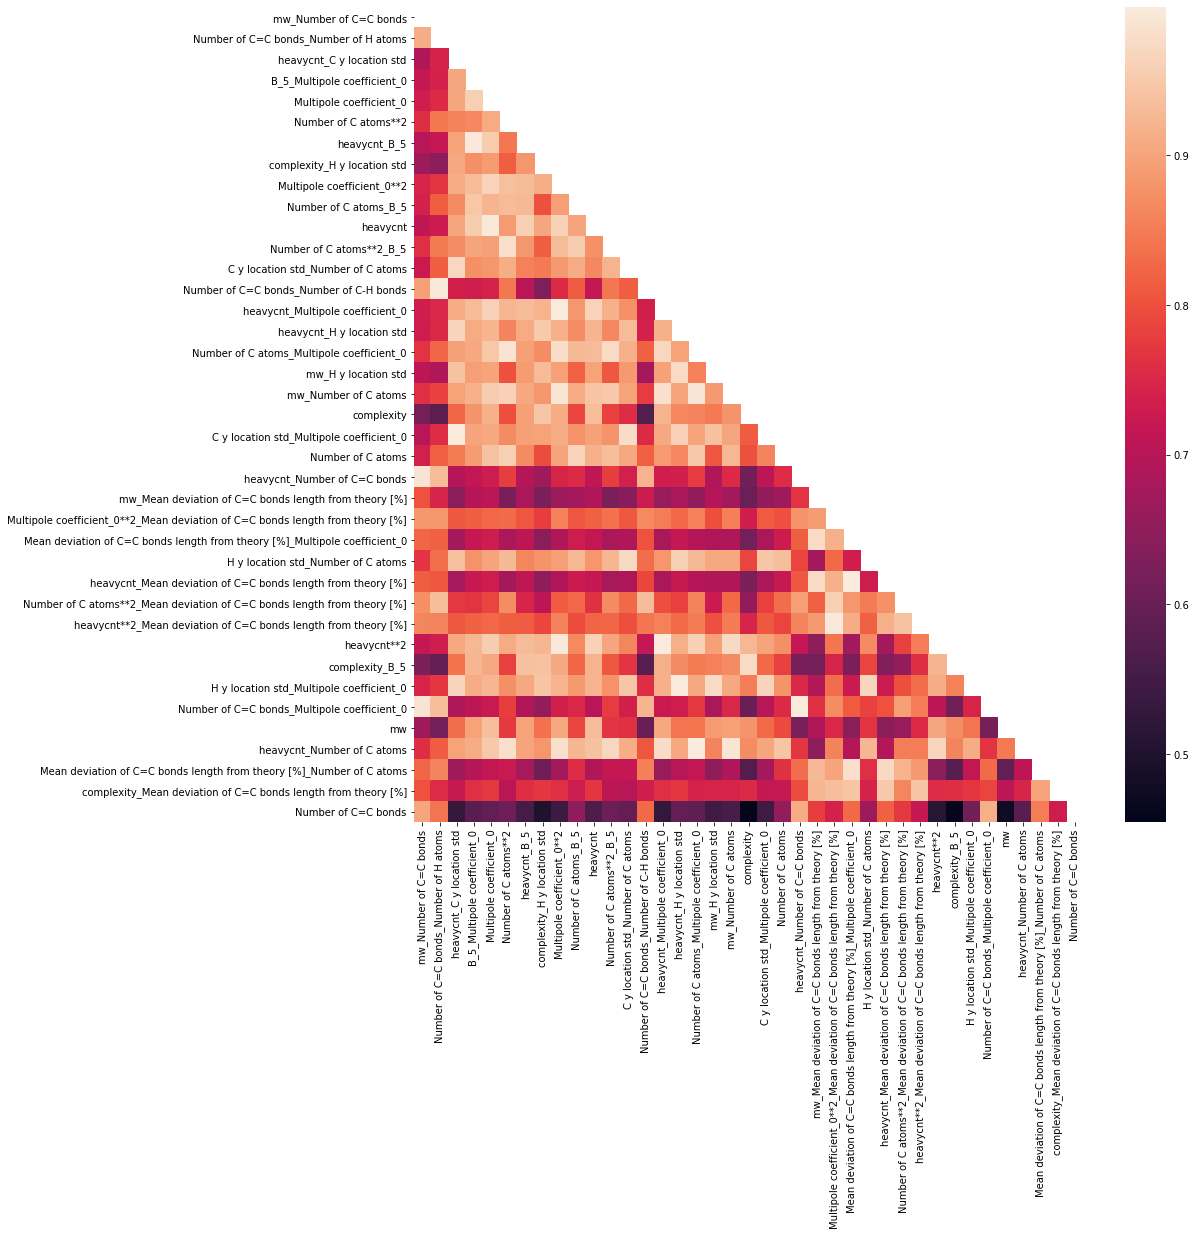

In [ ]:
estimator_optimizer.plot_corr_heatmap(selected_features_df)

In [ ]:
estimator_optimizer.get_corr_features_groups(selected_features_df)

[['Multipole coefficient_0**2_Mean deviation of C=C bonds length from theory [%]',
  'heavycnt**2_Mean deviation of C=C bonds length from theory [%]',
  'Number of C atoms**2_Mean deviation of C=C bonds length from theory [%]',
  'complexity_Mean deviation of C=C bonds length from theory [%]',
  'heavycnt_Mean deviation of C=C bonds length from theory [%]',
  'Mean deviation of C=C bonds length from theory [%]_Multipole coefficient_0',
  'Mean deviation of C=C bonds length from theory [%]_Number of C atoms',
  'mw_Mean deviation of C=C bonds length from theory [%]',
  'Number of C=C bonds_Number of H atoms',
  'mw_Number of C=C bonds',
  'heavycnt_Number of C=C bonds',
  'Number of C=C bonds_Multipole coefficient_0',
  'Number of C=C bonds_Number of C-H bonds',
  'heavycnt_Number of C atoms',
  'Multipole coefficient_0**2',
  'Number of C atoms_Multipole coefficient_0',
  'mw_Number of C atoms',
  'heavycnt_Multipole coefficient_0',
  'heavycnt**2',
  'Number of C atoms**2_B_5',
  'H y

In [ ]:
clf = RandomForestClassifier()
models_data=estimator_optimizer.iterate_features(clf, selected_features_df, target_column, metrics=['f1'], min_features_num=4, max_features_num=4, multiclass_classification=True)

In [ ]:
# 'mw_H y location std', 'C y location std_Multipole coefficient_0' 'heavycnt_Number of C=C bonds'
top_features = ['mw_H y location std', 'C y location std_Multipole coefficient_0', 'heavycnt_Number of C=C bonds', 'heavycnt_B_5', 'complexity_B_5']
top_features_df = selected_features_df[top_features]

In [ ]:
# new_df
X = top_features_df.to_numpy()
y = target_column.to_numpy().reshape(-1,1)

y_binarize = label_binarize(y, classes=[i for i in range(N_CLASSES)])

X_train, X_test, y_train, y_test = train_test_split(X, y_binarize, test_size=0.2, random_state=42)

In [ ]:
feature_importance = clf.feature_importances_
for index, feature in enumerate(top_features_df.columns):
    print(feature, feature_importance[index], '\n')

mw_H y location std 0.19170148301687542 

C y location std_Multipole coefficient_0 0.22839413558685062 

heavycnt_Number of C=C bonds 0.18269101897075818 

heavycnt_B_5 0.20567415422290505 

complexity_B_5 0.19153920820261067 



In [ ]:
X = new_df[important_features].to_numpy()
y = target_column.to_numpy().reshape(-1,1)

y_binarize = label_binarize(y, classes=[i for i in range(N_CLASSES)])

X_train, X_test, y_train, y_test = train_test_split(X, y_binarize, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
y_train_hat = clf.predict(X_train)
y_test_hat = clf.predict(X_test)
print(recall_score(y_train, y_train_hat, average='micro'), precision_score(y_train, y_train_hat, average='micro'), f1_score(y_train, y_train_hat, average='micro'))
print(recall_score(y_test, y_test_hat, average='micro'), precision_score(y_test, y_test_hat, average='micro'), f1_score(y_test, y_test_hat, average='micro'))

0.9997205728257073 0.9997205728257073 0.9997205728257073
0.3593182453199218 0.64851235501765 0.46242358863718086


In [ ]:
from sklearn.model_selection import GridSearchCV
grid_search_df = new_df[important_features]
clf = RandomForestClassifier(n_estimators=500)
tuned_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 30, 50, 70, 90, 110],
    'min_samples_split': [100, 150, 200, 250, 300]
    }
gs_cv = GridSearchCV(clf, tuned_params)
gs_cv.fit(X_train, y_train)

In [ ]:
gs_cv.best_params_

In [ ]:
y_train_hat = clf.predict(X_train)
y_test_hat = clf.predict(X_test)
from sklearn.metrics import recall_score, precision_score, f1_score
print(recall_score(y_train, y_train_hat, average='micro'), precision_score(y_train, y_train_hat, average='micro'), f1_score(y_train, y_train_hat, average='micro'))
print(recall_score(y_test, y_test_hat, average='micro'), precision_score(y_test, y_test_hat, average='micro'), f1_score(y_test, y_test_hat, average='micro'))

1.0 1.0 1.0
0.4070969544565521 0.7266832917705736 0.5218481375358166


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_hat, zero_division=1))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       451
           1       0.60      0.62      0.61       440
           2       0.55      0.54      0.55       424
           3       0.50      0.48      0.49       432
           4       0.49      0.48      0.49       469
           5       0.50      0.51      0.50       457
           6       0.53      0.53      0.53       445
           7       0.78      0.79      0.79       461

    accuracy                           0.59      3579
   macro avg       0.59      0.59      0.59      3579
weighted avg       0.59      0.59      0.59      3579



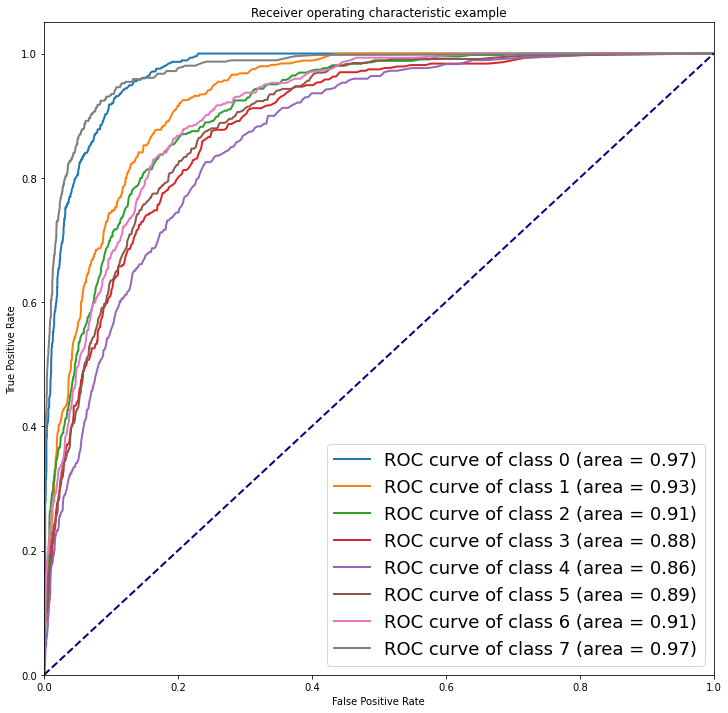

In [ ]:
FIGURE_SIZE = (12, 12)
LINE_WIDTH = 2
LEGEND_FONT_SIZE = 18
LEGEND_LOCATION = 'lower right'

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=FIGURE_SIZE)
for selected_class in range(N_CLASSES):
    plt.plot(fpr[selected_class], tpr[selected_class],
             lw=LINE_WIDTH, label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(selected_class, roc_auc[selected_class]))
plt.plot([0, 1], [0, 1], color='navy', lw=LINE_WIDTH, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc=LEGEND_LOCATION, prop={'size': LEGEND_FONT_SIZE})
plt.show()